# I. Description

In [ ]:
'''
- Data visualization
- Data processing (Image, NLP)
- EDA
- Object Detection
- Segmentation
- OCR
- Classification | feature extraction
- KNN: Image Retrieval
- Text query: Text-Image retrieval

- Lưu trữ ảnh làm sao??? Resize, nén ảnh, SVD, PCA
- THuật toán / model nào đó => COnvert từ video -> ảnh
HOG màu (TOp 2 năm 2021) => threshold => ảnh nào có chênh lệch màu lớn hơn threshold =>
=> Transnet

- Metadata: Segment, OD (100 class), OCR => tìm mối quan hệ của 3 kết quả trong 1 ảnh => bổ trợ cho model chính (text-image )
- PaddleOCR, MMDetection (best config)
BUild web:
- UI | Front End: JS (VueJS, React)/HTCM/CSS
- Backend: Database, Python (flask)
- Docker

Micro-Web Framework
'''

Với bài toán truy vấn ảnh, chắc hẳn các bạn cũng đã được làm quen ở trên lớp AIO. Vì thế mình sẽ tạm cho qua phần giới thiệu bài toán và chờ ban tổ chức cuộc thi công bố chính xác tập dữ liệu mình sẽ cập nhật mô tả chi tiết input + output cũng như pipeline của cuộc thi sau.

Hiện tại với đề bài là **Event Retrieval from Visual Data** mình sẽ chuẩn bị và hướng dẫn các bạn một pipeline cụ thể cũng như một số keyword để chuẩn bị cho cuộc thi sắp tới.

Khi tiếp cận pipeline này thì đối với một số bạn mới chưa biết về CNN hay một số kiến thức cơ bản về Deep Learning các bạn cần đọc qua về ý tưởng về CNN cũng như một số thao tác, các bước để chuẩn bị cho một quá trình training model. Ở đây mình sẽ cung cấp cho các bạn một số keyword để các bạn tìm hiểu như: *epoch, batch_size, learning_rate, decay, early_stop, ...* Với những thông tin cơ bản này các bạn hoàn toàn có thể train một model Deep Learning cho bài toán truy vấn ảnh này rồi.



Điều quan trọng nhất trong các cuộc thi mà mình hướng dẫn các nhóm tham gia đó là cần phải **hiểu** data mà mình cần xử lý.

![garbage in, garbage out](https://i0.wp.com/www.vamsitalkstech.com/wp-content/uploads/2017/08/gigo.png?resize=427%2C427)

**Vì sao chúng ta cần phải hiểu data?**

Trong một cuộc Hackathon thì data mà ban tổ chức cung cấp sẽ không bao giờ **sạch** mà sẽ luôn có những trường hợp như thông tin (hình ảnh) nhiễu, kém chất lượng, mất thông tin và còn nhiều trường hợp khác nữa. Đặc biệt là data bị mất cân bằng (imbalance data) - có thể hiểu đơn giản đây là trường hợp mà số lượng thông tin giữa các class trong data không bằng nhau. Ví dụ chúng ta có 5 class với số lượng ảnh trong mỗi class lần lượt là 1000-1000-700-200-10. Việc **hiểu** data sẽ giúp chúng ta có cái nhìn tổng quát về bài toán cũng như đánh giá được một số trường hợp dễ - trung bình - khó để chúng ta có thể chia nhỏ dữ liệu để xử lý từng bước một. Bên cạnh đó việc hiểu data cũng sẽ giúp chúng ta nắm được thông tin chung cơ bản của dataset như kích thước, số lượng object, thời tiết, ánh sáng, ... từ đó nắm rõ được phân phối dữ liệu và có những phương án xử lý phù hợp.

Mình sẽ cung cấp cho các bạn một số source code xử lý dữ liệu ảnh, tăng cường dữ liệu ảnh:
- [imgaug](https://github.com/aleju/imgaug)
- [albumentations](https://github.com/albumentations-team/albumentations)
- [torchio](https://github.com/fepegar/torchio)

**Phần tiếp theo mình sẽ cung cấp cho các bạn pipeline kèm code**


Đối với cuộc thi này mình muốn hướng các bạn sử dụng pytorch để triển khai giải pháp của nhóm. Về việc so sánh giữa torch và tensorflow mình sẽ giải thích cho các bạn ở một bài viết khác.

![pipeline retrieval](https://github.com/anminhhung/images/blob/main/cv/cnn/pipeline_retrieval.png?raw=true)

**Tại sao mình lại đề xuất pipeline này**

![landmark](https://storage.googleapis.com/kaggle-competitions/kaggle/8396/logos/thumb76_76.png?t=2018-02-02-15-58-42)

Trước khi bắt đầu tìm hiểu pipeline của mình thì mình sẽ cùng các bạn xét một ví dụ thực tế như sau: Có 3 bạn A, B, C cùng nhìn vào một tấm ảnh bên dưới. Bạn A nhìn vào ảnh thấy rằng "bầu trời trong ảnh thật đẹp", bạn B thì thấy "một tòa tháp đồng hồ", còn bạn C thì thấy "Một tòa lâu đài cổ trong ảnh". Ở ví dụ trên chúng ta thấy rằng mỗi người khi nhìn vào một tấm ảnh sẽ có một cái nhìn khác nhau và khi chúng ta tổng hợp lại những thông tin đó thì chúng ta sẽ có một bộ thông tin chi tiết để mô tả cho tấm ảnh.


Quay trở lại với pipeline mình đề xuất, mình đã sử dụng 3 model khác nhau (các bạn hoàn toàn có thể sử dụng nhiều model hơn là 3) với kỳ vọng như ví dụ trên là mỗi model sẽ rút trích ra được một bộ feature ảnh khác nhau và ta mong muốn tổng hợp những bộ feature đó lại để sử dụng nó cho các phép truy vấn ảnh sau này.

Với n model chúng ta sẽ có n vector feature cho mỗi bức ảnh. Đến đây mình cung cấp cho các bạn 3 chiến lược để có thể sử dụng, tổng hợp thông tin

Dưới đây là hình ảnh minh họa cho bước rút trích feature từ một model. Về source code cho bước rút trích feature này mình giới thiệu đến các bạn github này và hướng các bạn sử dụng vì github này update rất nhanh những SOTA mới.
- [timm github](https://github.com/rwightman/pytorch-image-models)

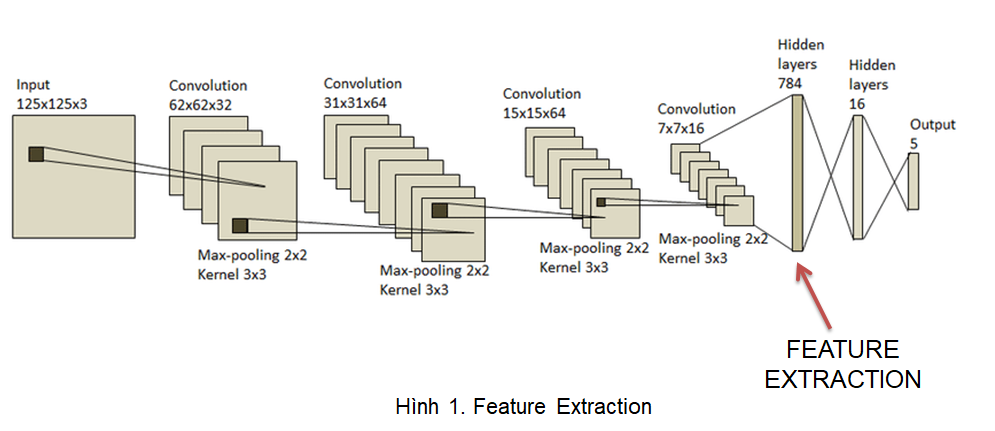

Ở phần query ảnh thì mình giới thiệu đến các bạn 2 source code mà mình thường xuyên sử dụng cho bài toán truy vấn ảnh là:
- [faiss](https://github.com/facebookresearch/faiss)
- [Annoy](https://github.com/spotify/annoy)

Sau khi thực hiện truy vấn chúng ta sẽ có kết quả như ví dụ sau:

![image](https://github.com/anminhhung/images/blob/main/learn_sc/query.png?raw=true)

Ở đây chúng ta thấy rằng có 4 bước ảnh trả về sai nhưng lại có 2 sai lại được sắp xếp thứ tự cao hơn những bức ảnh đúng. Vì vậy chúng ta cần sắp xếp lại thứ tự của chúng (Re-ranking)

![reranking](https://github.com/anminhhung/images/blob/main/learn_sc/query2.png?raw=true)

Ở bước re-ranking các bạn có thể tìm hiểu KNN search để giải quyết bài toán này.

In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1Muj-D9D5Z_OAI-xHwYt3wDGXoKJB8FT1

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Muj-D9D5Z_OAI-xHwYt3wDGXoKJB8FT1
From (redirected): https://drive.google.com/uc?id=1Muj-D9D5Z_OAI-xHwYt3wDGXoKJB8FT1&confirm=t&uuid=a9f25fb8-bc4c-4b87-8b37-f9b9049de6f4
To: /kaggle/working/image_data.zip
100%|██████████████████████████████████████| 1.94G/1.94G [00:22<00:00, 86.7MB/s]


In [ ]:
!unzip image_data.zip

In [ ]:
### Install Environment
!pip install timm
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 13.2 MB/s eta 0:00:0000:0100:01


# II. Example

In [ ]:
# Importing all the necessary libraries for the code to run.
import timm
import sys
import torch
import cv2
import numpy as np
import copy
import random
from PIL import Image
import faiss
from tqdm import tqdm, tqdm_notebook
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json

In [ ]:
import pandas as pd

df = pd.read_csv("image_data/data_description.txt")

dic_categories = df["class"].to_numpy().tolist()
dic_categories

['all_souls',
 'ashmolean',
 'balliol',
 'bodleian',
 'christ_church',
 'cornmarket',
 'hertford',
 'jesus',
 'keble',
 'magdalen',
 'new',
 'oriel',
 'oxford',
 'pitt_rivers',
 'radcliffe_camera',
 'trinity',
 'worcester']

In [ ]:
import os
import glob

files = []

for folder in os.listdir("image_data"):
  list_image_path = glob.glob(os.path.join("image_data", folder, "*.jpg"))
  files.extend(list_image_path)

id2img_fps = dict(enumerate(files))
# Creating a dictionary of image file paths.
with open('image_path.json', 'w') as f:
  f.write(json.dumps(id2img_fps))

In [ ]:
### Load index Images
def jsonKeys2int(js):
    """
    It takes a json file and converts all the keys to integers

    :param js: the json file
    :return: A dictionary with the keys as integers and the values as the image file paths.
    """
    if isinstance(js, dict):
            return {int(k):v for k,v in js.items()}
    return js

with open('image_path.json', 'r') as f:
  id2img_fps = jsonKeys2int(json.loads(f.read()))

### Load model

In [ ]:
# Listing all the pretrained models available in the timm library.
import timm
from pprint import pprint

In [ ]:
# It creates a model from the timm library, and then allows you to pass in an image path and get a
# prediction
class Model():
  def __init__(self, model_name, size=(224,224)):
    self.model = timm.create_model(str(model_name), pretrained=True, num_classes=0)
    self.size = size

  def __call__(self, image_path):
    image = self.preprocessing_image(image_path)
    return self.model(image)

  def eval(self):
    self.model.eval()

  def preprocessing_image(self, image_path):
    image = Image.open(str(image_path)).resize(self.size)
    return torch.as_tensor(np.array(image, dtype=np.float32)).transpose(2,0)[None]

In [ ]:
# Creating a model object.
xception41_model = Model('xception41')
resnest50d_model = Model('resnet50')
adv_inception_model = Model('adv_inception_v3')

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name adv_inception_v3 to current inception_v3.tf_adv_in1k.
  model = create_fn(


### Required function

In [ ]:
def show_imgs(query, f_ids):
  """
  It takes in a query image and a list of filepaths to images, and displays the query image and the
  top 6 images from the list of filepaths

  :param query: the image we want to find similar images to
  :param f_ids: the list of file ids of the images that are most similar to the query image
  """
  plt.imshow(query)
  fig = plt.figure(figsize=(12, 12))
  columns = 3
  rows = 2
  for i in range(1, columns*rows +1):
    img = mpimg.imread(id2img_fps[f_ids[i - 1]])
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")
  plt.show()

In [ ]:
def inference(query_path, retrieval_func, index):
  """
  Given a query image, we use the retrieval function to extract the feature vector of the query image.
  Then, we use the index to search for the top-k nearest neighbors of the query image

  :param query_path: the path to the query image
  :param retrieval_func: The function that will be used to retrieve the embedding of the query image
  :param index: the index object that we created earlier
  """
  query = retrieval_func(query_path).detach().numpy()
  scores, idx_image = index.search(query, k=7)
  return scores[0], idx_image[0]

In [ ]:
# It takes a retrieval function and a database of images, and returns a faiss index
class my_faiss():
  def normal(self, image_path):
    return xception41_model(image_path)

  def mean(self, image_path):
    """
    It takes an image path, runs it through three different models, concatenates the outputs, and then
    takes the mean of the concatenated outputs

    :param image_path: the path to the image you want to classify
    :return: The mean of the three models.
    """
    o1 = xception41_model(image_path)
    o2 = resnest50d_model(image_path)
    o3 = adv_inception_model(image_path)
    concat = torch.concat((o1, o2, o3), dim=0)
    mean = torch.mean(concat, dim=0, keepdim=True)
    return mean

  def concat(self, image_path):
    """
    > The function takes an image path as input, and returns the concatenated output of three different
    models

    :param image_path: the path to the image
    :return: The concatenated output of the three models.
    """
    o1 = xception41_model(image_path)
    o2 = resnest50d_model(image_path)
    o3 = adv_inception_model(image_path)
    concat = torch.concat((o1, o2, o3), dim=1)
    return concat

  def __call__(self, retrieval_name, DB):
    if retrieval_name == 'mean':
      num_index = 2048
      retrieval_func = self.mean
    elif retrieval_name == 'normal':
      num_index = 2048
      retrieval_func = self.normal
    elif retrieval_name == 'concat':
      num_index = 6144
      retrieval_func = self.concat
    else:
      raise Exception("Your way dont supported")

    self.index = faiss.IndexFlatL2(num_index)
    for img_index, img in tqdm_notebook(DB.items()):
      # try:
      embedded = retrieval_func(img).detach().numpy()
      self.index.add(embedded)
      # except Exception as e:
      #   print('error: ', e)
      #   continue
    return self.index

### Faiss normal

In [ ]:
### Create bin file
normal_faiss = my_faiss()
normal_idx = normal_faiss('normal', id2img_fps)

/tmp/ipykernel_33/764541343.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_index, img in tqdm_notebook(DB.items()):


  0%|          | 0/5063 [00:00<?, ?it/s]

In [ ]:
#### Save bin file ####
faiss.write_index(normal_idx, 'faiss_normal.bin')

In [ ]:
#### load Index by bin file ####
normal_idx = faiss.read_index('faiss_normal.bin')

In [ ]:
### Inference
query_path = 'image_data/ashmolean/ashmolean_000217.jpg'
normal_scores, normal_ids = inference(query_path, normal_faiss.normal, normal_idx)

print(f"scores: {normal_scores}")
print(f"idx: {normal_ids}")

scores: [0.        6.5151396 6.775775  6.7999415 6.830821  6.852876  6.8701   ]
idx: [1987 3527 4313 4357 3460  977 3545]


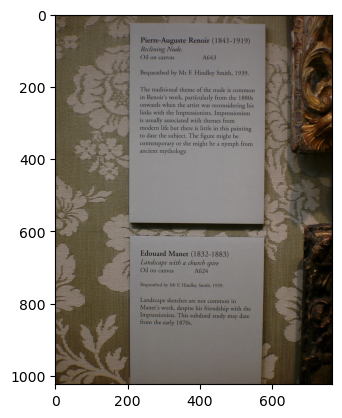

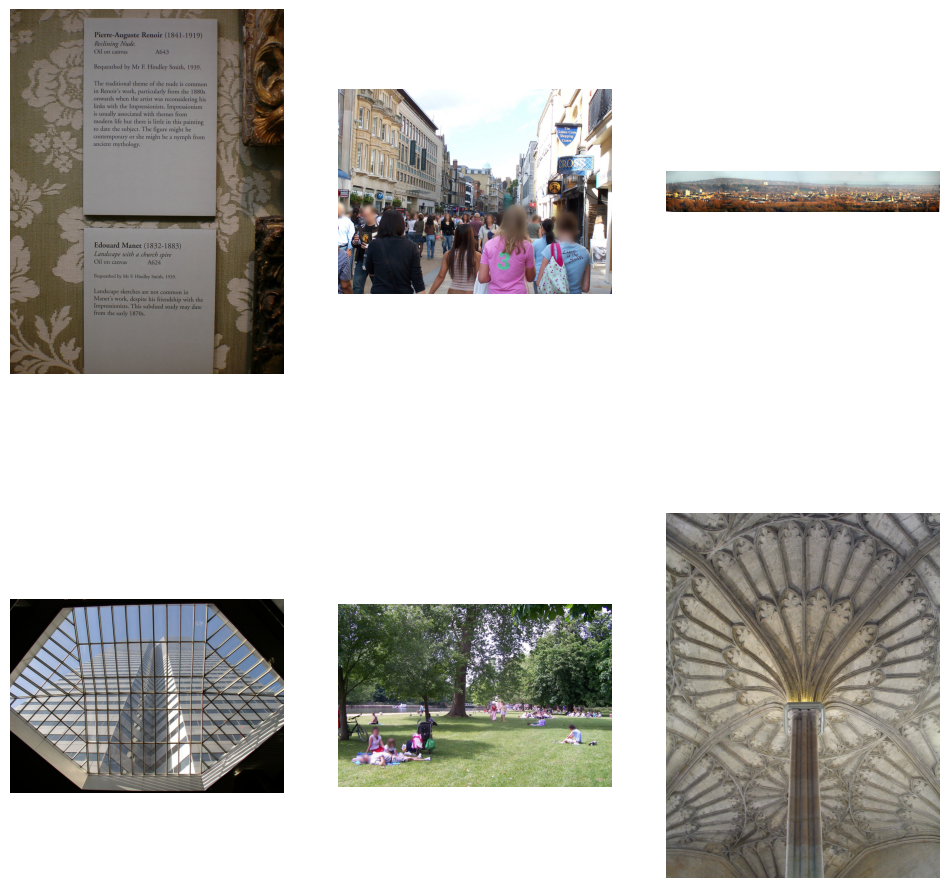

In [ ]:
query = Image.open(query_path)
show_imgs(query, normal_ids)

Faiss Mean

In [ ]:
mean_faiss = my_faiss()
mean_idx = mean_faiss('mean', id2img_fps)

/tmp/ipykernel_33/764541343.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_index, img in tqdm_notebook(DB.items()):


  0%|          | 0/5063 [00:00<?, ?it/s]

In [ ]:
#### Save bin file ####
faiss.write_index(normal_idx, 'faiss_mean.bin')

In [ ]:
#### Load Index by bin file ####
mean_idx = faiss.read_index('faiss_mean.bin')

In [ ]:
### Inference
query_path = 'image_data/pitt_rivers/pitt_rivers_000008.jpg'
mean_scores, mean_result_ids = inference(query_path, mean_faiss.mean, mean_idx)

print(f"scores: {mean_scores}")
print(f"idx: {mean_result_ids}")

scores: [5.1462054 5.171883  5.332303  5.364186  5.4234567 5.4502287 5.48543  ]
idx: [2160 3824 5056 2300 3629 3147 2088]


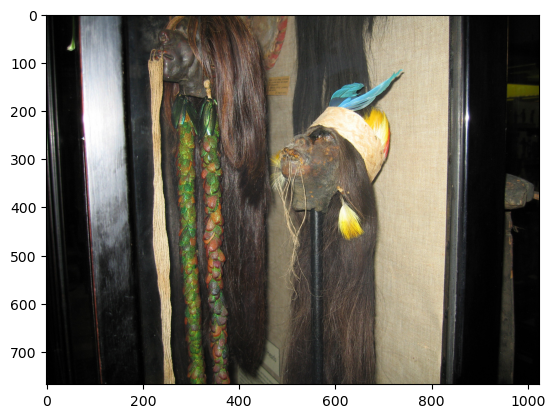

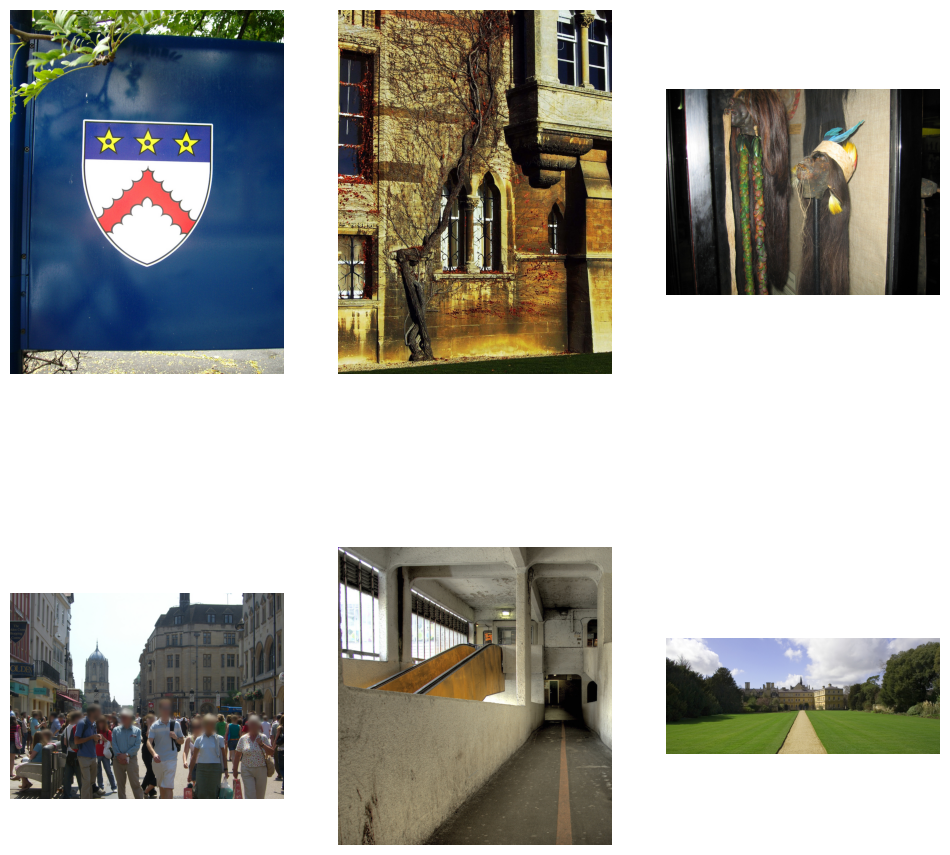

In [ ]:
query = Image.open(query_path)
show_imgs(query, mean_result_ids)

Faiss concat

In [ ]:
concat_faiss = my_faiss()
concat_idx = concat_faiss('concat', id2img_fps)

In [ ]:
#### Save bin file ####
faiss.write_index(normal_idx, 'faiss_concat.bin')

In [ ]:
#### Load Index by bin file ####
concat_idx = faiss.read_index('faiss_concat.bin')

In [ ]:
### Inference
query_path = 'image_data/keble/keble_000182.jpg'
concat_scores, concat_ids = inference(query_path, concat_faiss.concat, concat_idx)

print(f"scores: {concat_scores}")
print(f"idx: {concat_ids}")

scores: [0.        6.9575925 7.060535  7.0642266 7.0823636 7.095705  7.1223993]
idx: [2204 2645 3460 4313 4218 1021 3684]


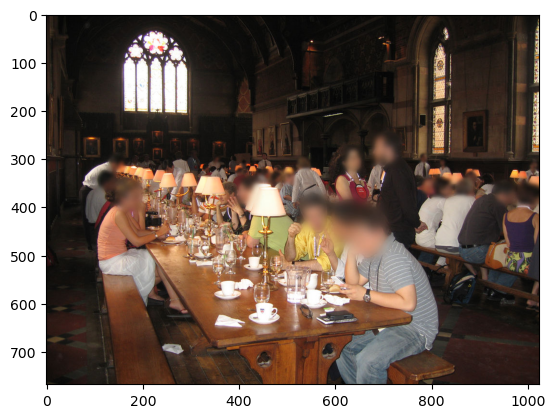

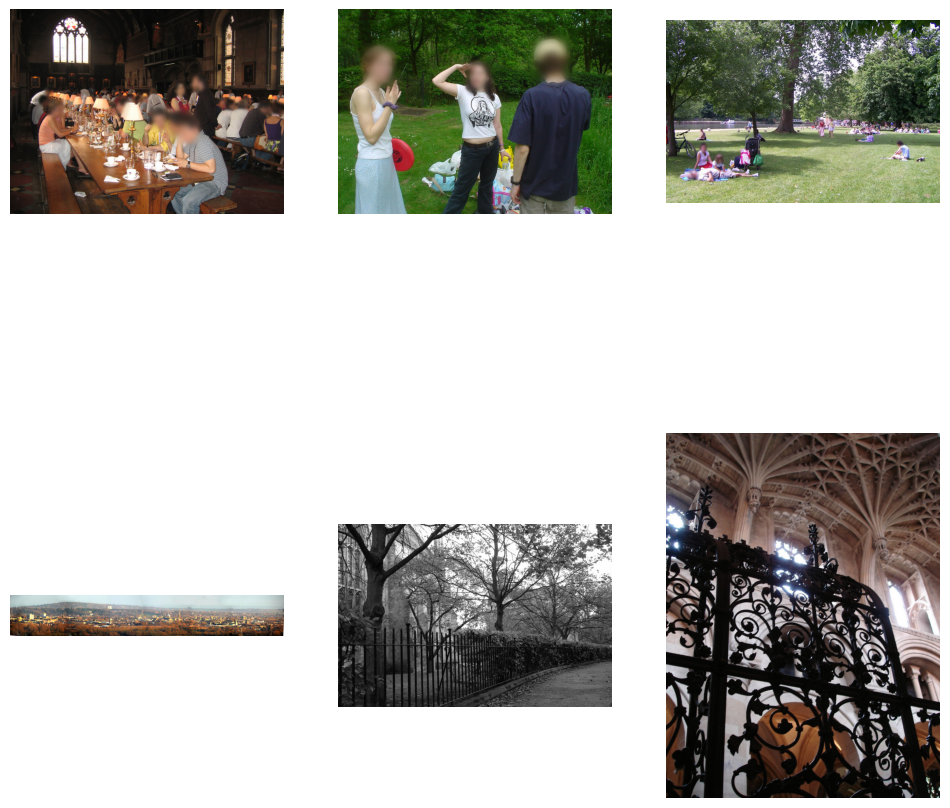

In [ ]:
query = Image.open(query_path)
show_imgs(query, concat_ids)